In [14]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import json
import numpy as np
import utils
import loaders
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dfc = loaders.load_countries()
dfd = loaders.load_disciplines()
dfe = loaders.load_events()
dfa = loaders.load_athletes()
dfm = loaders.load_medallists()
medal_table = loaders.load_medal_table()

In [7]:
dfa['age'] = (dfa['dob'].apply(lambda x: (pd.Timestamp.now() - x)).dt.days / 365.25)
dft = dfm.join(dfa, on='athlete_id', rsuffix='_athlete')
dft.sort_values('age')

,athlete_id,country_id,event_id,discipline_id,date,medal_type,name,tvName,dob,gender,role,country_id_athlete,disciplineList,eventList,age
468,1946064,AUS,SKBWPARK,SKB,2024-08-06,ME_GOLD,TREW Arisa,Arisa TREW,2010-05-12,Female,Athlete,AUS,[SKB],[SKBWPARK],14.255989
766,1902055,JPN,SKBWSTREET,SKB,2024-07-28,ME_GOLD,YOSHIZAWA Coco,YOSHIZAWA Coco,2009-09-22,Female,Athlete,JPN,[SKB],[SKBWSTREET],14.891170
1415,1902069,JPN,SKBWSTREET,SKB,2024-07-28,ME_SILVER,AKAMA Liz,AKAMA Liz,2009-01-08,Female,Athlete,JPN,[SKB],[SKBWSTREET],15.594798
1418,1902075,JPN,SKBWPARK,SKB,2024-08-06,ME_SILVER,HIRAKI Cocona,HIRAKI Cocona,2008-08-26,Female,Athlete,JPN,[SKB],[SKBWPARK],15.964408
1853,1544123,GBR,SKBWPARK,SKB,2024-08-06,ME_BRONZE,BROWN Sky,Sky BROWN,2008-07-07,Female,Athlete,GBR,[SKB],[SKBWPARK],16.101300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1540,1564893,TUR,SHOXAPMT,SHO,2024-07-30,ME_SILVER,DIKEC Yusuf,Yusuf DIKEC,1973-01-01,Male,Athlete,TUR,[SHO],"[SHOMAPM, SHOXAPMT]",51.613963
214,1914909,GER,EQUODRESTEAM,EQU,2024-08-03,ME_GOLD,WERTH Isabell,Isabell WERTH,1969-07-21,Female,Athlete,GER,[EQU],"[EQUODRESINDV, EQUODRESTEAM]",55.063655
213,1914909,GER,EQUODRESINDV,EQU,2024-08-04,ME_SILVER,WERTH Isabell,Isabell WERTH,1969-07-21,Female,Athlete,GER,[EQU],"[EQUODRESINDV, EQUODRESTEAM]",55.063655
1867,1970910,GBR,EQUODRESTEAM,EQU,2024-08-03,ME_BRONZE,HESTER Carl,Carl HESTER,1967-06-29,Male,Athlete,GBR,[EQU],"[EQUODRESINDV, EQUODRESTEAM]",57.125257


count    11110.000000
mean        27.097110
std          5.404414
min         12.005476
25%         23.394935
50%         26.528405
75%         30.067077
max         69.700205
Name: age, dtype: float64

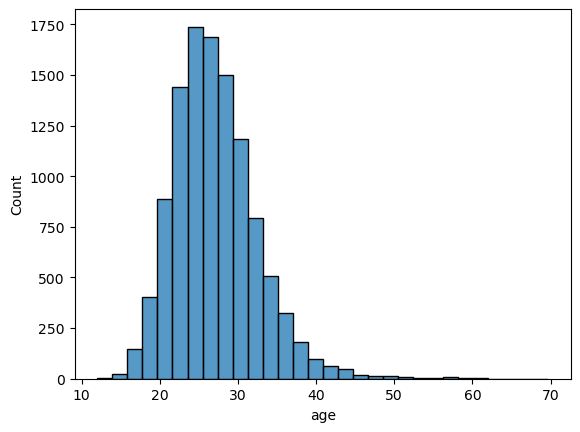

In [9]:
# Age distribution
sns.histplot(dfa['age'], bins=30)
dfa['age'].describe()

In [240]:
# Country success rates
events_partcipated_in = dfa.explode('eventList')[['country_id', 'eventList']].drop_duplicates().groupby('country_id').size()
events_won = dfm.drop_duplicates(['country_id', 'event_id']).groupby('country_id').size()
dft = events_partcipated_in.to_frame('events_partcipated_in').join(events_won.to_frame('events_won')).fillna(0)
dft['success_rate'] = dft['events_won'] / dft['events_partcipated_in']
dft = dft[dft['success_rate'] > 0]
dftt = dft.sort_values('success_rate', ascending=False).join(dfc['country_name']).reset_index()
dftt[dftt.country_name == 'India']

,country_id,events_partcipated_in,events_won,success_rate,country_name
66,IND,69,6.0,0.086957,India


# Medals data

In [3]:
df = medal_table.set_index('country_id').join(dfc['country_name']).reset_index().set_index('country_name')
df = df[df['country_id'] != 'EOR']

# Add population data
population_data = utils.get_population_data(df.index.unique().tolist())
population_df = pd.DataFrame.from_dict(population_data, orient='index', columns=['population'])
df = df.join(population_df)

unmatched_country_names=set()


In [4]:
# Add GDP data
gdp_data = utils.get_gdp_data(df.index.unique().tolist())
gdp_df = pd.DataFrame.from_dict(gdp_data, orient='index', columns=['gdp'])
gdp_df['gdp'] = gdp_df['gdp'].astype(float)
df = df.join(gdp_df)

unmatched_country_names=set()


In [13]:
df['gdp_per_capita'] = df['gdp'] / df['population']
df['medals_per_gdp_per_capita'] = df['total'] / df['gdp_per_capita']
dft = df.sort_values('medals_per_gdp_per_capita', ascending=False)
dft.sort_values('medals_per_gdp_per_capita', ascending=False).head(10)

,country_id,rank,gold,silver,bronze,total,unique_disciplines_won,unique_events_won,population,gdp,gdp_per_capita,medals_per_gdp_per_capita
country_name,,,,,,,,,,,,
China,CHN,2,40,27,24,91,23,82,1422584933,18532633.0,0.013027,6985.258323
Kenya,KEN,17,4,2,5,11,1,10,55339003,104001.0,0.001879,5853.107499
Uzbekistan,UZB,13,8,2,3,13,5,13,35652307,97956.0,0.002748,4731.512016
Kyrgyzstan,KGZ,68,0,2,4,6,2,6,7073516,13599.0,0.001923,3120.898301
Ethiopia,ETH,47,1,3,0,4,1,4,128691692,205130.0,0.001594,2509.466036
Tajikistan,TJK,79,0,0,3,3,2,3,10389799,12953.0,0.001247,2406.345789
Ukraine,UKR,22,3,5,4,12,7,11,37732836,188943.0,0.005007,2396.458360
IR Iran,IRI,21,3,6,3,12,2,12,90608707,464181.0,0.005123,2342.414886
India,IND,71,0,1,5,6,4,6,1438069596,3937011.0,0.002738,2191.616324


In [40]:
df['medals_per_million'] = df['total'] / df['population'] * 1e6
df['medals_per_billion_usd'] = df['total'] / df['gdp'] * 1000

In [42]:
df.sort_values('gdp', ascending=False)

,country_id,rank,gold,silver,bronze,total,unique_disciplines_won,unique_events_won,population,gdp,medals_per_million,medals_per_billion_usd
country_name,,,,,,,,,,,,
United States,USA,1,40,44,42,126,34,107,343477335,28781083.0,0.366836,0.004378
China,CHN,2,40,27,24,91,23,82,1422584933,18532633.0,0.063968,0.004910
Germany,GER,10,12,13,8,33,19,32,84548231,4591100.0,0.390310,0.007188
Japan,JPN,3,20,12,13,45,16,44,124370947,4110452.0,0.361821,0.010948
India,IND,71,0,1,5,6,4,6,1438069596,3937011.0,0.004172,0.001524
...,...,...,...,...,...,...,...,...,...,...,...,...
Cabo Verde,CPV,84,0,0,1,1,1,1,522331,2718.0,1.914495,0.367918
Saint Lucia,LCA,55,1,1,0,2,1,2,179285,2582.0,11.155423,0.774593
Grenada,GRN,80,0,0,2,2,1,2,117081,1406.0,17.082191,1.422475


In [28]:
dft = df.sort_values('medals_per_billion_usd', ascending=False).reset_index()
dft[dft.total == 6].sort_values('medals_per_million', ascending=False)

,country_name,country_id,rank,gold,silver,bronze,total,unique_disciplines_won,unique_events_won,population,gdp,medals_per_million,medals_per_billion_usd
5,Jamaica,JAM,44,1,3,2,6,1,6,2839786,20098.0,2.112835,0.298537
3,Kyrgyzstan,KGZ,68,0,2,4,6,2,6,7073516,13599.0,0.848234,0.441209
89,DPR Korea,PRK,68,0,2,4,6,4,6,26418204,NaN,0.227116,NaN
49,South Africa,RSA,44,1,3,2,6,4,6,63212384,373233.0,0.094918,0.016076
64,Thailand,THA,44,1,3,2,6,4,6,71702435,548890.0,0.083679,0.010931
88,India,IND,71,0,1,5,6,4,6,1438069596,3937011.0,0.004172,0.001524


In [50]:
dft = df.merge(dfa.groupby('country_id').size().to_frame('num_athletes'), left_on='country_id', right_index=True)
dft['medals_per_athlete'] = dft['total'] / dft['num_athletes']
dftt = dft.sort_values('medals_per_athlete', ascending=False).reset_index()
dftt[dftt['country_name'] == 'India']

,country_name,country_id,rank,gold,silver,bronze,total,unique_disciplines_won,unique_events_won,population,gdp,medals_per_million,medals_per_billion_usd,num_athletes,medals_per_athlete
67,India,IND,71,0,1,5,6,4,6,1438069596,3937011.0,0.004172,0.001524,112,0.053571
